In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [28]:
!pip install -U datasets

In [29]:
%%capture
!pip install transformers==4.19.2
!pip install rouge_score

In [30]:
from datasets import load_metric
import pandas as pd
df= pd.read_csv('/content/drive/MyDrive/CodeCycle/articlesSet.csv')
df.head()

,title,summary,content
0,Mental Note Vol. 24,"Irrespective of gender, race, age or religion ...",Photo by Josh Riemer on Unsplash<|n|><|n|>Merr...
1,Your Brain On Coronavirus,These pathways converge and mediate brain heal...,Your Brain On Coronavirus<|n|><|n|>A guide to ...
2,Mind Your Nose,Learning a new language or reading more books ...,Mind Your Nose<|n|><|n|>How smell training can...
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,Passionate about the synergy between science a...
4,Surviving a Rod Through the Head,"What about him?” Well, let’s just say that he ...","You’ve heard of him, haven’t you? Phineas Gage..."


In [31]:
print(df.shape)
df=df.dropna()
print(df.shape)

(1155, 3)
(1062, 3)


In [32]:
df['length'] = df.content.map(lambda x: len(x.split(" ")))


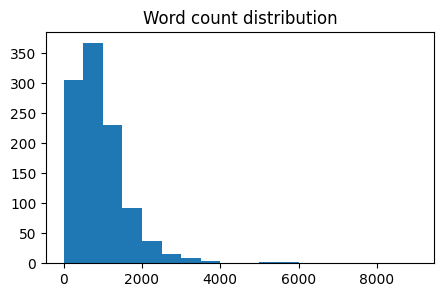

In [33]:
numOfWords=df.length
from matplotlib import pyplot as plt
fig= plt.figure(figsize =(5, 3))
plt.hist(numOfWords.to_numpy(), bins = [0,500,1000,1500,2000,2500,3000,3500,4000,5000,6000,7000,8000,9000])
plt.title("Word count distribution")
plt.show()

In [34]:
tempDf=df[df.length<=800]
tempDf =tempDf[tempDf.length>=100]
tempDf.shape

(536, 4)

In [35]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/led-base-16384')

loading configuration file https://huggingface.co/allenai/led-base-16384/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ec844bead6f5bbcd6ac727b57e595c2ba40b0970f91cb923423773f72fe1702f.898baac75d55d484b1b1de95b8ab791987c78591acf36ce6131b56d0d2d26af7
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "gradient_checkpointing"

In [36]:

max_input_length = 1024
max_output_length = 1024
Batch_size = 4

def process_data_to_model_inputs(batch):
    # tokenize the inputs and labels
    inputs = tokenizer(
        batch["summary"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
    )
    outputs = tokenizer(
        batch["content"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
    )
    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask
    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [1 for _ in range(len(batch["input_ids"][0]))]
    ]
    batch["global_attention_mask"][0][0]=1
    batch["labels"] = outputs.input_ids

    batch["labels"] = [
       [-100 if token == tokenizer.pad_token_id else token for token in labels]
       for labels in batch["labels"]
    ]
    return batch

In [37]:
import numpy as np
train, validate,test = np.split(tempDf.sample(frac=1, random_state=42), [int(.4*len(tempDf)), int(.5*len(tempDf))])
print(train.shape)
print(validate.shape)


(214, 4)
(54, 4)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [38]:
train=train[0:250]
validate=validate[25:50]
print(train.shape)
print(validate.shape)

(214, 4)
(25, 4)


In [39]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train)
validate_dataset = Dataset.from_pandas(validate)

In [40]:
train_dataset = train_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=Batch_size,
    remove_columns=["content","summary","length","__index_level_0__"],
)

Map:   0%|          | 0/214 [00:00<?, ? examples/s]

In [44]:

val_dataset = validate_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=Batch_size,
    remove_columns=["content","summary","length","__index_level_0__"],
)

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

In [45]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)

In [46]:

from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
led=AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384",gradient_checkpointing=True,use_cache=False)
led.config.num_beams=2
led.config.max_length=1024
led.config.min_length=512
led.config.length_penalty=2.0
led.config.early_stopping=True
led.config.no_repeat_ngram_size=3

rouge =load_metric("rouge")


def compute_metrics(pred):
    labels_ids=pred.label_ids
    pred_ids=pred.predictions

    pred_str=tokenizer.batch_decode(pred_ids,skip_special_tokens=True)
    labels_ids[labels_ids==-100]=tokenizer.pad_token_id
    label_str=tokenizer.batch_decode(labels_ids,skip_special_tokens=True)

    rouge_output=rouge.compute(predictions=pred_str,references=label_str,rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }



training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=Batch_size,
    per_device_eval_batch_size=Batch_size,

    output_dir="./",
    logging_steps=5,
    save_steps=10,
    eval_steps=10,
    save_total_limit=2,

    gradient_accumulation_steps=4,
    num_train_epochs=2
)




loading configuration file https://huggingface.co/allenai/led-base-16384/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ec844bead6f5bbcd6ac727b57e595c2ba40b0970f91cb923423773f72fe1702f.898baac75d55d484b1b1de95b8ab791987c78591acf36ce6131b56d0d2d26af7
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "gradient_checkpointing"

In [47]:
trainer=Seq2SeqTrainer(
    model=led,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [56]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `LEDForConditionalGeneration.forward` and have been ignored: title. If title are not expected by `LEDForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 214
  Num Epochs = 2
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 26
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/

OutOfMemoryError: CUDA out of memory. Tried to allocate 786.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 577.06 MiB is free. Process 7360 has 14.18 GiB memory in use. Of the allocated memory 12.11 GiB is allocated by PyTorch, and 1.94 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [49]:
sample = tempDf.sample(frac=0.005, random_state=12)
sample.shape

(3, 4)

In [50]:
sample = sample[['content','summary']]
sample['content']


,content
935,"“Keep a notebook. Travel with it, eat with it,..."
816,How Ad Limits Will Work on Facebook<|n|><|n|>T...
38,3 Marketing Strategies That Can Work Like Magi...


In [52]:
sample['summary']

,summary
935,Slap into it every stray thought that flutters...
816,How Ad Limits Will Work on Facebook<|n|><|n|>T...
38,"With the world getting smaller day by day, it’..."


In [55]:
from datasets import Dataset
pubmed_test=Dataset.from_pandas(sample)
import torch
from datasets import load_dataset, load_metric
from transformers import LEDTokenizer, LEDForConditionalGeneration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = LEDTokenizer.from_pretrained("/content/runs/Sep08_07-13-34_99ab2af7b599/1725779621.5996437")
model = LEDForConditionalGeneration.from_pretrained("/content/runs/Sep08_07-13-34_99ab2af7b599/1725780815.0933282/events.out.tfevents.1725780815.99ab2af7b599.620.2").to(device).half()
def generate_answer(batch):
    inputs_dict = tokenizer(
        batch["summary"],
        padding="max_length",
        truncation=True,
        max_length=1024,
        return_tensors="pt",
    )
    input_ids = inputs_dict.input_ids.to(device)
    attention_mask = inputs_dict.attention_mask.to(device)
    global_attention_mask = torch.zeros_like(attention_mask)

    predicated_abstract_ids = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        global_attention_mask=global_attention_mask)
    batch["predicated_content"] = tokenizer.batch_decode(
        predicated_abstract_ids, skip_special_tokens=True
    )
    return batch
result =pubmed_test.map(generate_answer, batched=True, batch_size=2)

Didn't find file /content/runs/Sep08_07-13-34_99ab2af7b599/1725779621.5996437/vocab.json. We won't load it.
Didn't find file /content/runs/Sep08_07-13-34_99ab2af7b599/1725779621.5996437/merges.txt. We won't load it.
Didn't find file /content/runs/Sep08_07-13-34_99ab2af7b599/1725779621.5996437/added_tokens.json. We won't load it.
Didn't find file /content/runs/Sep08_07-13-34_99ab2af7b599/1725779621.5996437/special_tokens_map.json. We won't load it.
Didn't find file /content/runs/Sep08_07-13-34_99ab2af7b599/1725779621.5996437/tokenizer_config.json. We won't load it.


OSError: Can't load tokenizer for '/content/runs/Sep08_07-13-34_99ab2af7b599/1725779621.5996437'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure '/content/runs/Sep08_07-13-34_99ab2af7b599/1725779621.5996437' is the correct path to a directory containing all relevant files for a LEDTokenizer tokenizer.

In [ ]:
result['content'][1]


In [ ]:
result['predicated_content'][1]